In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import os
from reload_recursive import reload_recursive

from mri_data import file_manager as fm
import helpers

In [2]:
reload_recursive(helpers)

## Setup

### Paths and Config

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
pd.options.display.precision = 3
colors = helpers.get_colors()

### Functions

In [4]:
def melt_df(df, id_vars=None, value_vars=None, value_name=None, var_name=None):
    if var_name is None:
        var_name = "variable"
    if value_name is None:
        value_name = "value"

    df_melt = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        value_name=value_name,
        var_name=var_name,
    )

    for i, row in df_melt.iterrows():
        if "choroid" in row[var_name]:
            df_melt.loc[i, "struct"] = "choroid"
        elif "pineal" in row[var_name]:
            df_melt.loc[i, "struct"] = "pineal"
        elif "pituitary" in row[var_name]:
            df_melt.loc[i, "struct"] = "pituitary"

        if "man" in row[var_name]:
            df_melt.loc[i, "segmentation"] = "ground truth"
        elif "auto" in row[var_name]:
            df_melt.loc[i, "segmentation"] = "inference"

    return df_melt

### Load and Prepare Data

#### Model Testing

In [7]:
analysis_dir = Path("/home/srs-9/Projects/ms_mri/analysis")
train_df = pd.read_csv(
    analysis_dir / "choroid_pineal_pituitary_crosstrain_t1" / "dataframe.csv",
    index_col="subid",
)
train_df2 = pd.read_csv(
    analysis_dir / "choroid_pineal2_pituitary_crosstrain_t1" / "dataframe.csv",
    index_col="subid",
)

train_df = helpers.set_dz_type5(train_df)
train_df2 = helpers.set_dz_type5(train_df2)

#### Inference

In [5]:
df = pd.read_csv(data_dir / "t1_data_full.csv", index_col="subid")
df2 = pd.read_csv(data_dir / "t1_aschoplex_data_full.csv", index_col="subid")

df2['pineal_volume'] = df['pineal_volume']
df2['pituitary_volume'] = df['pituitary_volume']

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dzdur",
    "extracted_EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
]


def prepare_df_full(df):
    df = df.loc[:, keep_cols]

    df = helpers.set_dz_type5(df)
    df = helpers.set_dz_type3(df)
    df = helpers.set_dz_type2(df)
    df = helpers.fix_edss(df)
    df = helpers.clean_df(df)
    df = helpers.set_has_prl(df)

    df.rename(columns={"lesion_vol_cubic": "t2lv"}, inplace=True)
    df = df.rename(columns={"extracted_EDSS": "EDSS"})

    df = helpers.do_sqrt_transform(df, ["EDSS", "MSSS", "ARMSS", "gMSSS"])
    df = helpers.do_log_transform(df, ["t2lv"])

    numeric_vars = [
        "age",
        "dzdur",
        "Female",
        "EDSS",
        "EDSS_sqrt",
        "MSSS",
        "MSSS_sqrt",
        "gMSSS",
        "gMSSS_sqrt",
        "ARMSS",
        "ARMSS_sqrt",
        "DMT_score",
        "DMT_hx_all",
        "TER",
        "DMF",
        "NAT",
        "INF",
        "thalamus",
        "brain",
        "white",
        "grey",
        "cortical_thickness",
        "lesion_count",
        "t2lv",
        "t2lv_logtrans",
        "PRL",
        "tiv",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
    ]

    for var in numeric_vars:
        df[var] = df[var].astype("float")

    df = helpers.clean_dz_type(df)
    return df


df = prepare_df_full(df)
df2 = prepare_df_full(df2)

#### Melt Data

In [8]:
train_cp_vols = melt_df(
    train_df,
    id_vars=["dz_type5"],
    value_vars=[
        "choroid_vol_man",
        "choroid_vol_auto",
    ],
    value_name="volume",
)

train_pin_vols = melt_df(
    train_df,
    id_vars=["dz_type5"],
    value_vars=[
        "pineal_vol_man",
        "pineal_vol_auto",
    ],
    value_name="volume",
)

train_pit_vols = melt_df(
    train_df,
    id_vars=["dz_type5"],
    value_vars=[
        "pituitary_vol_man",
        "pituitary_vol_auto",
    ],
    value_name="volume",
)

cp_vols = melt_df(
    df,
    id_vars=["dz_type5"],
    value_vars=["choroid_volume"],
    value_name="volume",
)

pin_vols = melt_df(
    df,
    id_vars=["dz_type5"],
    value_vars=["pineal_volume"],
    value_name="volume",
)

pit_vols = melt_df(
    df,
    id_vars=["dz_type5"],
    value_vars=["pituitary_volume"],
    value_name="volume",
)

cp_vols2 = melt_df(
    df2,
    id_vars=["dz_type5"],
    value_vars=["choroid_volume"],
    value_name="volume",
)

pin_vols2 = melt_df(
    df2,
    id_vars=["dz_type5"],
    value_vars=["pineal_volume"],
    value_name="volume",
)

pit_vols2 = melt_df(
    df2,
    id_vars=["dz_type5"],
    value_vars=["pituitary_volume"],
    value_name="volume",
)

df_comp = df2
df_comp.rename(
    columns={
        "choroid_volume": "choroid_volume2",
        "pineal_volume": "pineal_volume2",
        "pituitary_volume": "pituitary_volume2",
    },
    inplace=True,
)
df_comp["choroid_volume"] = df["choroid_volume"]
df_comp["pineal_volume"] = df["pineal_volume"]
df_comp["pituitary_volume"] = df["pituitary_volume"]

cp_comp = df_comp.melt(
    id_vars=["dz_type5"],
    value_vars=["choroid_volume", "choroid_volume2"],
    value_name="volume",
)
pin_comp = df_comp.melt(
    id_vars=["dz_type5"],
    value_vars=["pineal_volume", "pineal_volume2"],
    value_name="volume",
)
pit_comp = df_comp.melt(
    id_vars=["dz_type5"],
    value_vars=["pituitary_volume", "pituitary_volume2"],
    value_name="volume",
)

## Distributions

### Training Data

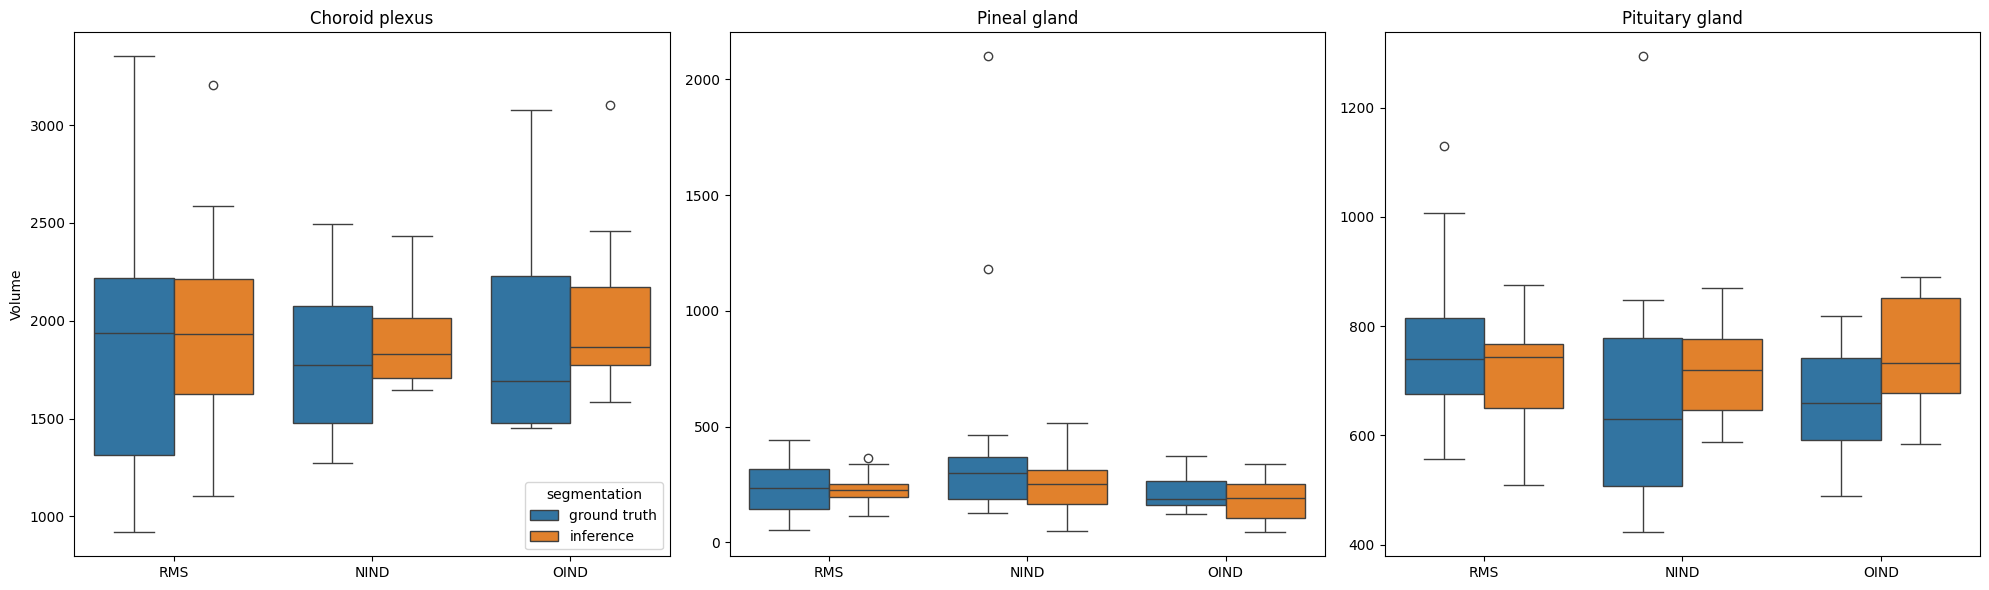

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.boxplot(data=train_cp_vols, x="dz_type5", y="volume", hue="segmentation", ax=ax)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.boxplot(
    data=train_pin_vols,
    x="dz_type5",
    y="volume",
    hue="segmentation",
    ax=ax,
    legend=False,
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.boxplot(
    data=train_pit_vols,
    x="dz_type5",
    y="volume",
    hue="segmentation",
    ax=ax,
    legend=False,
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

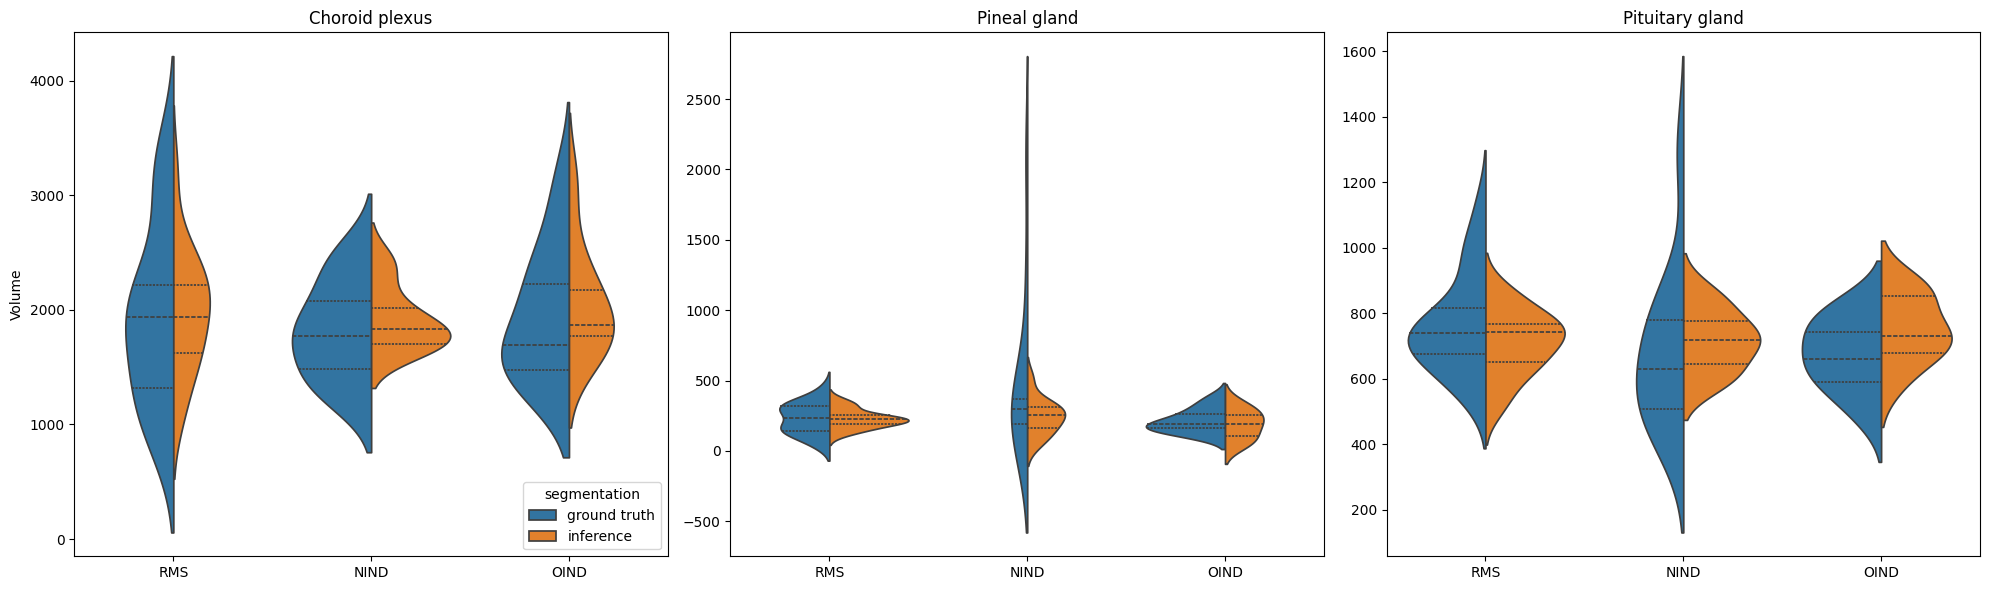

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.violinplot(data=train_cp_vols, x="dz_type5", y="volume", hue="segmentation", split=True, inner="quart", ax=ax)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.violinplot(
    data=train_pin_vols, x="dz_type5", y="volume", hue="segmentation", split=True, inner="quart", ax=ax, legend=False
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.violinplot(
    data=train_pit_vols, x="dz_type5", y="volume", hue="segmentation", split=True, inner="quart", ax=ax, legend=False
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

### Inference

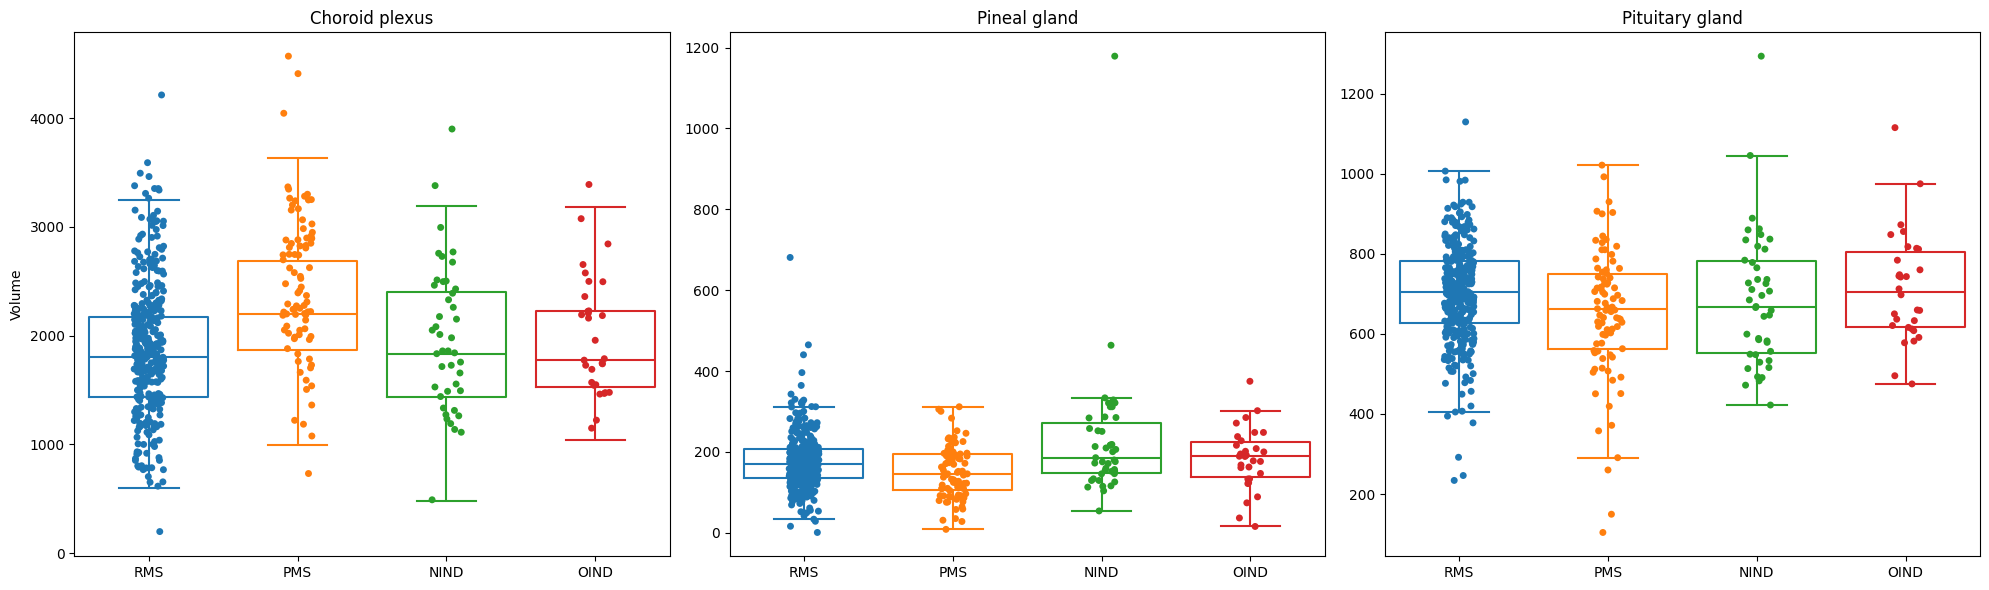

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.stripplot(data=cp_vols2, x="dz_type5", y="volume", hue="dz_type5", ax=ax)
sns.boxplot(
    data=cp_vols2,
    x="dz_type5",
    y="volume",
    hue="dz_type5",
    fliersize=0,
    fill=False,
    ax=ax,
)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.stripplot(
    data=pin_vols2, x="dz_type5", y="volume", hue="dz_type5", ax=ax, legend=False
)
sns.boxplot(
    data=pin_vols2,
    x="dz_type5",
    y="volume",
    hue="dz_type5",
    fliersize=0,
    fill=False,
    ax=ax,
    legend=False,
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.stripplot(
    data=pit_vols2, x="dz_type5", y="volume", hue="dz_type5", ax=ax, legend=False
)
sns.boxplot(
    data=pit_vols2,
    x="dz_type5",
    y="volume",
    hue="dz_type5",
    fliersize=0,
    fill=False,
    ax=ax,
    legend=False,
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

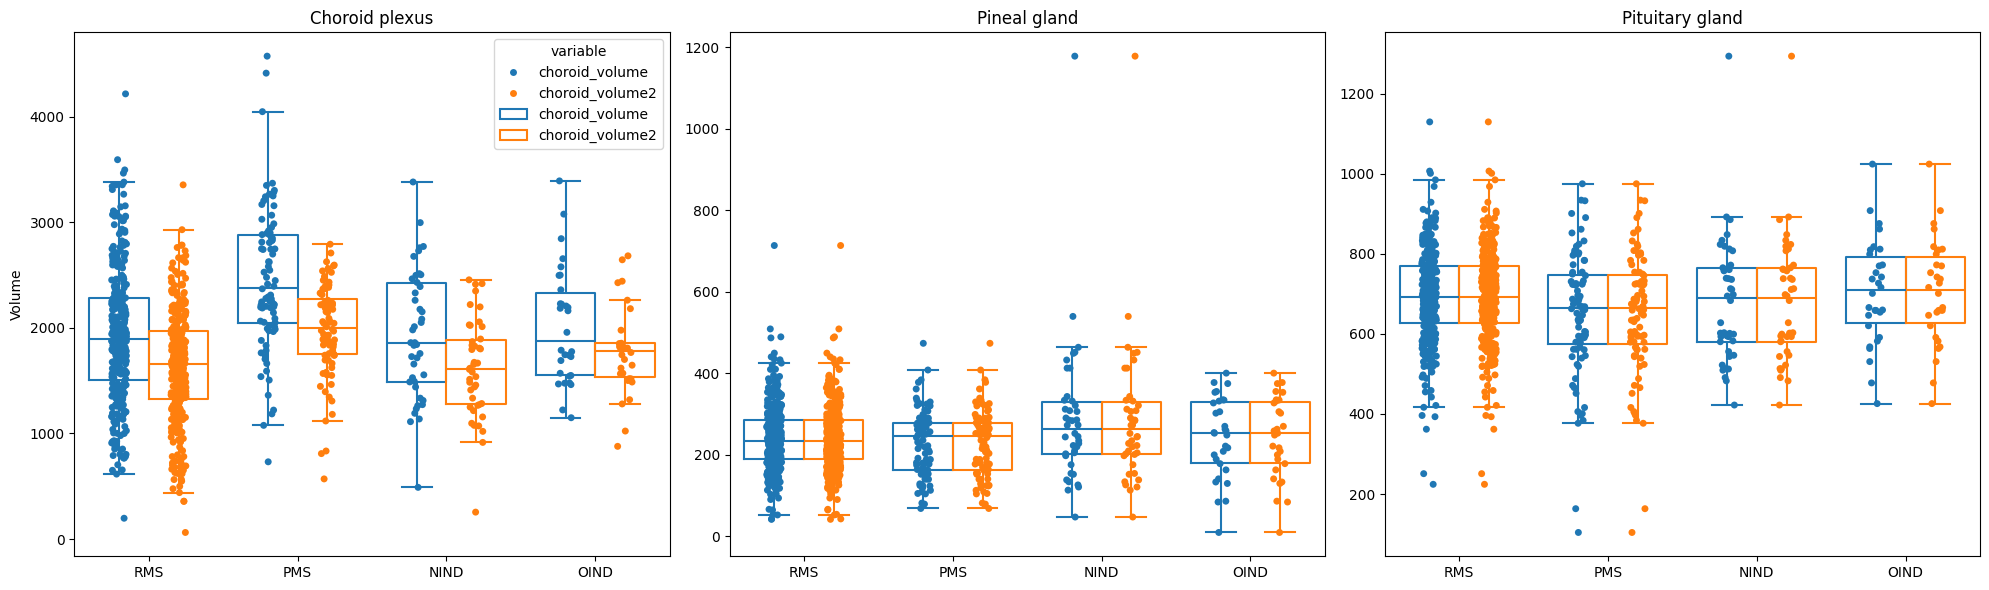

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.stripplot(data=cp_comp, x="dz_type5", y="volume", hue="variable", dodge=True, ax=ax)
sns.boxplot(
    data=cp_comp,
    x="dz_type5",
    y="volume",
    hue="variable",
    fliersize=0,
    fill=False,
    ax=ax,
)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.stripplot(
    data=pin_comp, x="dz_type5", y="volume", hue="variable", dodge=True, ax=ax, legend=False
)
sns.boxplot(
    data=pin_comp,
    x="dz_type5",
    y="volume",
    hue="variable",
    fliersize=0,
    fill=False,
    ax=ax,
    legend=False,
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.stripplot(
    data=pit_comp, x="dz_type5", y="volume", hue="variable", dodge=True, ax=ax, legend=False
)
sns.boxplot(
    data=pit_comp,
    x="dz_type5",
    y="volume",
    hue="variable",
    fliersize=0,
    fill=False,
    ax=ax,
    legend=False,
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

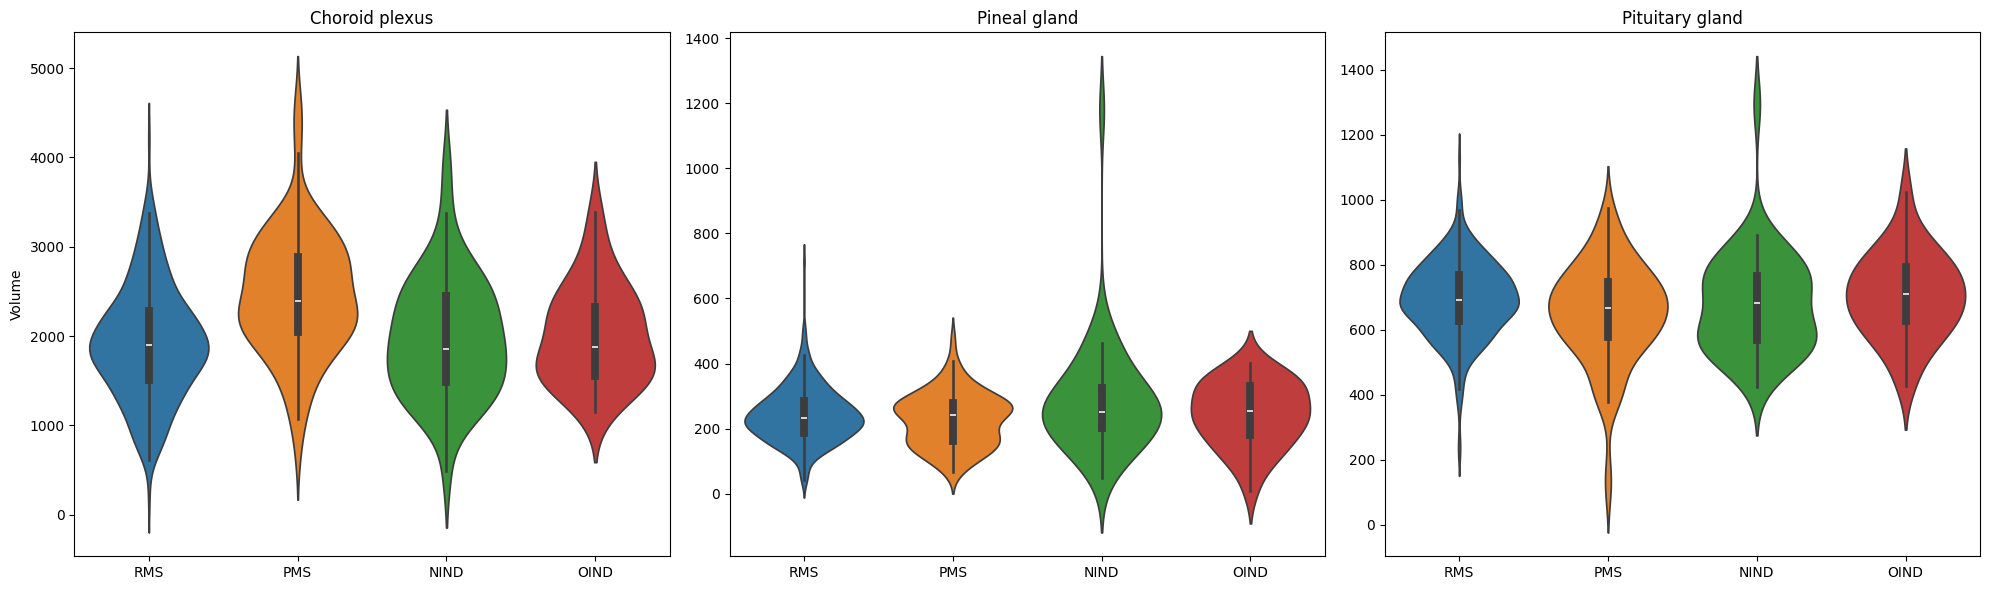

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.violinplot(data=cp_vols, x="dz_type5", y="volume", hue="dz_type5", ax=ax)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.violinplot(
    data=pin_vols, x="dz_type5", y="volume", hue="dz_type5", ax=ax, legend=False
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.violinplot(
    data=pit_vols, x="dz_type5", y="volume", hue="dz_type5", ax=ax, legend=False
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

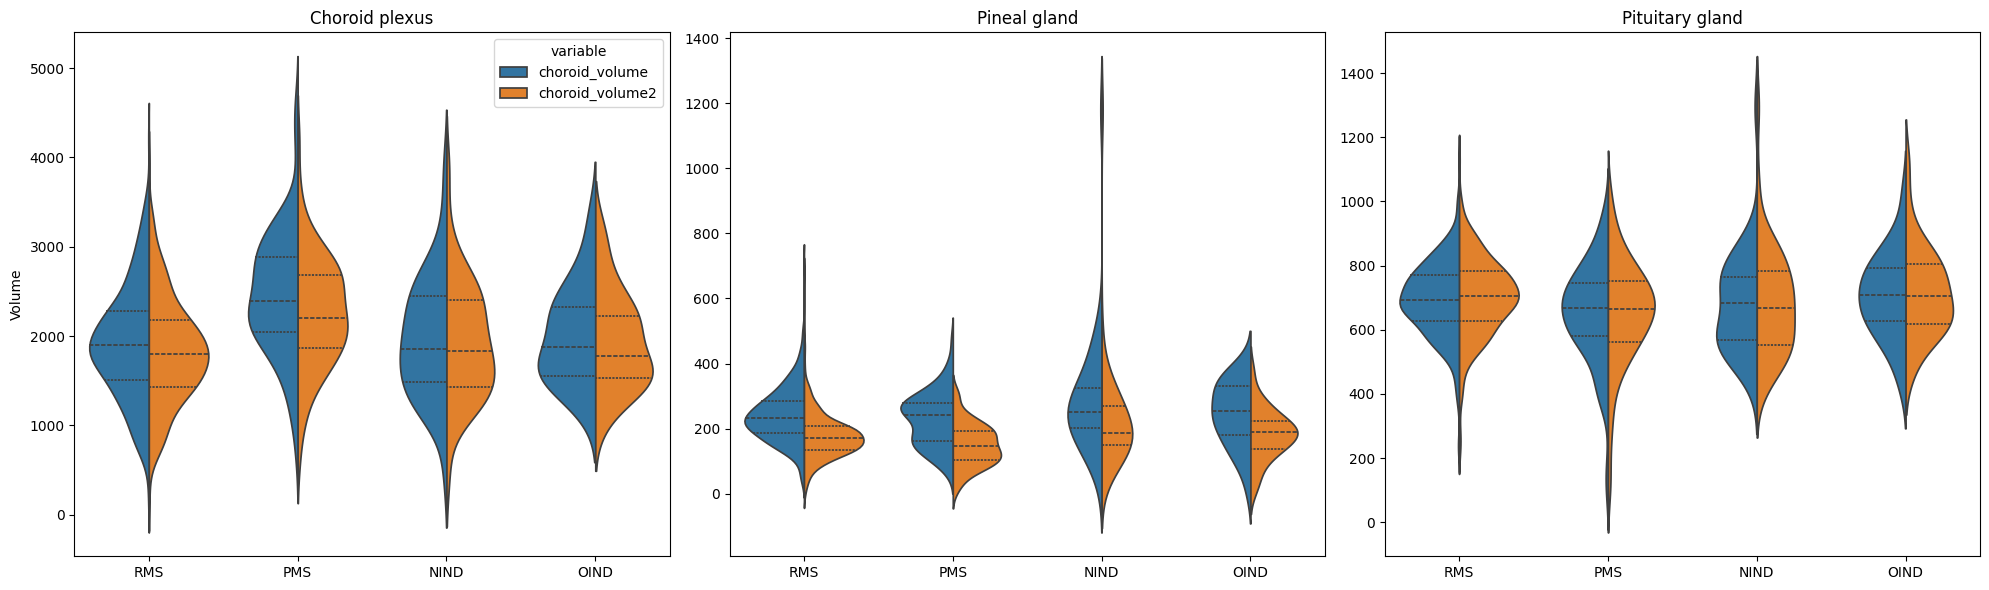

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), layout="tight")

ax = axes[0]
sns.violinplot(data=cp_comp, x="dz_type5", y="volume", hue="variable", split=True, inner="quart", ax=ax)
ax.set_title("Choroid plexus")
ax.set_ylabel("Volume")
ax.set_xlabel("")

ax = axes[1]
sns.violinplot(
    data=pin_comp, x="dz_type5", y="volume", hue="variable", split=True, inner="quart", ax=ax, legend=False
)
ax.set_title("Pineal gland")
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[2]
sns.violinplot(
    data=pit_comp, x="dz_type5", y="volume", hue="variable", split=True, inner="quart", ax=ax, legend=False
)
ax.set_title("Pituitary gland")
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()